In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.410853  0.205105  0.193065  0.596335 -0.817910 -1.011665 -0.032258   
  1  -0.524567 -0.454265  0.197032  0.923653  0.078916  0.128741 -0.432307   
  2  -0.124282  0.533911 -0.550400  0.381160  0.443954  0.913540 -0.279009   
  3  -0.055005 -0.556068 -0.779929 -0.006755 -0.796232 -0.933784 -1.027660   
  4   0.675891  0.109951  0.952269  1.262392  1.025108 -0.670963 -1.480502   
  5   0.143063  0.416881  0.475909  0.657529 -0.087354 -0.337175 -1.150296   
  6   0.041370 -0.341640  0.075364  0.849594  0.686877 -0.914225 -0.577130   
  7  -0.191983  0.319720  0.530471 -0.725132  0.282568 -0.644199 -0.641107   
  8  -0.516898 -0.100771 -0.250380  0.158532  0.097487 -1.051889 -0.778453   
  9   0.861445  0.163282 -0.483572 -0.603403  0.081350 -0.421319 -0.699020   
  10 -0.126734 -0.449526  0.941810  0.834446  0.228380 -0.544133 -0.053028   
  11  0.149393  0.881810 -0.028625 -0.402402 -0.508882 -0.191279  1.143921   
  12 -0.079649  0.014107 -0.296328  0.353707 -0.403341 -0.670885 -0.590803   
  13 -0.459773  0.139214  0.837779  0.912255  0.787144  0.082385 -0.047241   
  14  0.089655 -0.139178  0.651614  0.143534 -0.214488 -0.258995 -0.240636   
  15  0.786462  0.615628 -0.322398  0.308433  0.457567  0.161429 -0.198180   
  16 -0.831005  0.620364  0.565106  0.159266 -0.507554  0.332828  0.145667   
  17 -1.265648 -0.225471 -0.147541  0.528552 -0.148280 -0.443499  0.086686   
  18 -0.520788 -0.105570  0.268365 -0.096805 -1.669659 -1.356942 -0.408565   
  19 -0.693783  0.908198  0.748272  0.232731  0.778051 -0.374512 -0.807265   
  20 -0.648575  0.843312  0.223688  0.819702  0.895430  0.454993 -0.101824   
  21  0.043546  0.152156  0.195667  0.091566 -0.745386 -0.692141 -0.255942   
  22  0.118103  0.002926  1.236431  0.773499 -0.621420  0.242943 -0.213198   
  23 -0.881888 -0.353180 -0.191411  0.198947  0.327354  0.823360 -0.747380   
  24 -0.542440  0.796989  0.126228  0.713169 -0.108578 -0.388896 -0.835989   
1 0  -0.713753  0.659573  0.238981  0.438034  0.349003  1.036929 -0.147526   
  1  -0.675170 -0.059631  0.420135  0.251900  0.447920  0.312037 -0.514758   
  2   0.378233  0.309982  0.797904  0.821895 -0.242055 -0.156023 -0.524896   
  3   0.186368  0.028906  0.172316  0.986672  0.157384  0.734293 -0.564369   
  4   0.000450  0.146625  0.504256  0.525014 -0.015499  0.140098 -0.914710   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.626135  0.513299 -0.233322  ...  0.933525  0.168709  0.383497   
  1   0.338678  0.687238 -0.284339  ...  0.087171 -0.512747  0.189629   
  2   0.270270  0.241424 -0.074998  ... -1.113133 -0.506999  0.293182   
  3  -0.136437  0.469628 -0.314635  ...  0.368310  0.680164 -0.828987   
  4  -0.049490  0.808765 -0.481182  ...  0.418154 -0.632268  1.033040   
  5   0.053133  0.292840  0.426018  ...  0.020145 -0.769960 -0.726566   
  6  -0.488115  1.121178 -0.404957  ... -0.281703 -0.278456 -0.104039   
  7  -1.249367  0.195742 -0.637026  ... -0.906837  0.545801 -0.270985   
  8  -0.466527  0.567008  0.478152  ...  0.337845 -0.706723 -0.013351   
  9   0.909255  0.006196 -0.550403  ...  0.778027 -1.059344 -0.827468   
  10  0.847851  0.344074 -0.847825  ...  0.359116  0.356626  0.105990   
  11  0.490594  1.013734 -0.511540  ... -0.625377  0.120268 -0.349887   
  12 -1.977923 -0.013112 -0.331279  ... -0.277298 -0.665478 -0.876592   
  13 -0.676279 -0.579719 -1.025636  ... -0.023000  0.617716 -0.125547   
  14  0.730611 -0.295204 -0.867510  ...  0.088059  0.519421  0.712844   
  15 -0.280518 -0.545564  0.733573  ...  0.502246  0.201632  0.177946   
  16 -0.153807  0.058531 -0.172957  ... -0.162402 -0.029625  0.106476   
  17 -0.704633 -0.431830 -0.957532  ...  1.004528 -0.634592 -0.027213   
  18 -0.264704  1.298203 -0.692712  ...  0.705039 -0.580014 -0.956862   
  19 -0.796145  1.128756 -0.010827  ... -0.518251 -0.183132  1.018662   
  20 -0.625846  0.525977  0.454435  ... -0.235352 -0.533030 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.005774  0.043552  23.093841  5.339150e-118  0.920415  1.091134


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



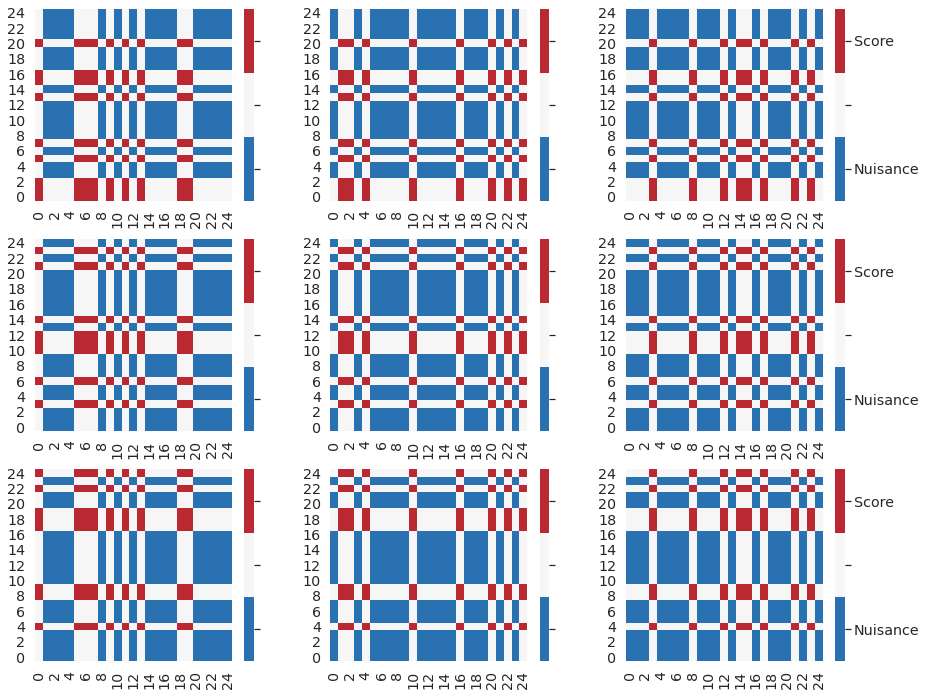

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



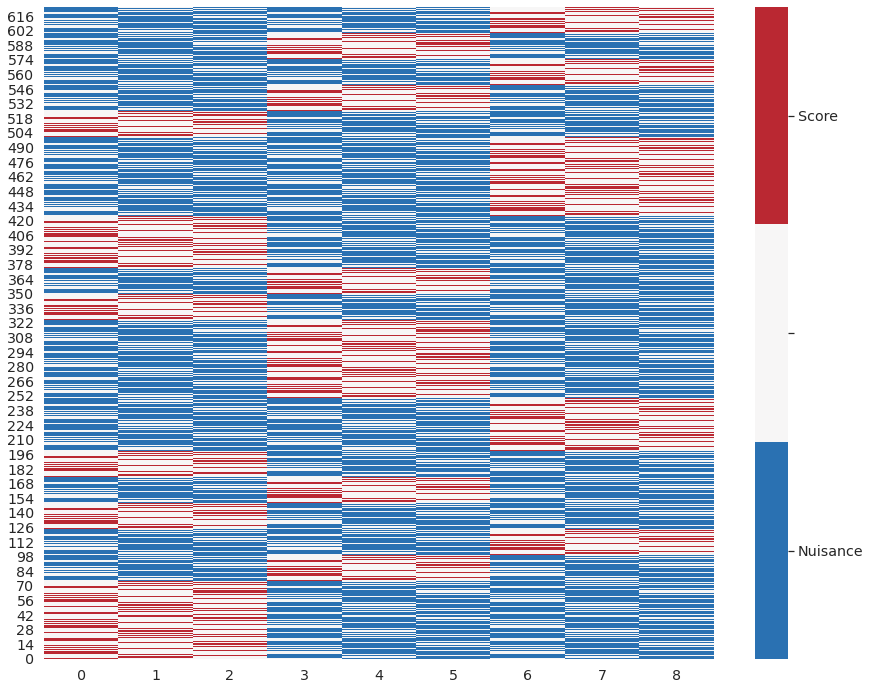

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])